# Traveling Salesman Problem and Genetic Algorithms (GA)

Following from: https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

Additional methods for recombination and mutation were derived from: [Introduction to Evolutionary Computing 2nd Edition](https://link.springer.com/content/pdf/10.1007/978-3-662-44874-8.pdf)

## Recombination Methods
### Order Crossover (OX)
Copies a section of an existing route into the new route, then starting at the end of the section, the values of another route are copied over into the new route if they are not already in it while still preverving their order.

### Partially Mapped Crossover (PMX)
Functions in a similar manner to OX.  A random section of a route is copied over into the new route, but there is an extra step copying elements from the second route before PMX follows the rest of the behavior of OX.

### Edge Crossover (EX)
Generates a new route from two routes in the population by prioritizing shared edges and, when one isn't found, picking a city that connects to the smallest number of cities.  When there is a tie, or no city that matches the previous critieria, a city is randomly chosen from the available options.  Once a city is selected, it is removed from the list.  This process is repeated until there are no cities left to add.

## Mutation Methods
### Swap Mutation
Given a route, it randomly selects two elements in the route and swaps their location.

### Inversion Mutation
Given a route, it randomly selects two positions in the route and reverses the order of the elements between them.

In [11]:
%matplotlib notebook
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
import TravelingSalesman as TSP

In [12]:
cityList = [] #Stores all the generated cities

for i in range(0,25):
    cityList.append(TSP.City(x=int(random.random() * 200), y=int(random.random() * 200)))

In [13]:
#These are passed into the different genetic algorithm functions.

popSize = 100 #How large of a population to generate
eSize = 20 #The number of "fittest" individuals to carry over into the next generation
mRate = 0.05 #Should be between 0.0-1.0. Likelihood of a mutation occurring in a child.
gens = 500 #How many generations to run the simulation for.

#These will terminate a simulation early if the population becomes stagnant over X amount of generations.
perChange = 0.05 #How much change should occur in the fitness of the best route of a generation to continue the simulation.
maxFlatGens = 50 #How many generations can pass without change greater than or equal to perChange occurring.

In [14]:
#Generate a population for testing
pop = TSP.initialPopulation(popSize = popSize, cityList = cityList)

In [15]:
def DetermineChange(value, generation, perChange = 0.05, maxFlatGens = 50, reset = False):
    '''  
    Narrative: Calculate the percent of change between value and the previous value that 

    Parameters:
        value: The current best value of the current generation of the population.
        generation: An integer.  The generation that value was created in.
        perChange: A value between 0.0-1.0.  The minimum amount that value has to have changed from orig
                    to be set as the new value of orig.
        maxFlatGens: An integer.  The maximum number of generations that can pass without a value having
                        a percentage of change greater than or equal to perChange.
        reset: A boolean.  Resets the value of orig when true.
    '''
    #Makes orig function like a "static" variable and keep its value between function calls
    if 'orig' not in DetermineChange.__dict__:
        DetermineChange.orig = (value, generation)
        
    if DetermineChange.orig == None:
        DetermineChange.orig = (value, generation)
        
    proceed = True
        
    if reset:
        DetermineChange.orig = None
        
    else:
        perc = abs(DetermineChange.orig[0] - value) / DetermineChange.orig[0]

        if perc < perChange and abs(DetermineChange.orig[1] - generation) >= maxFlatGens:
            proceed = False
        elif perc > perChange:
                DetermineChange.orig = (value, generation)
                
    return proceed

In [16]:
def geneticAlgorithmVariationTest(population, eliteSize, mutationRate, generations, childMethod, mutationMethod, runs):
    '''  
    Narrative: Generates a graph with the performance of each run of the specified recombination and mutation combination.

    Parameters:
        population: A list of possible routes to take between the cities.
        eliteSize: How many of the "fittest" routes to carry over into the next generation
        mutationRate: A value between 0.0-1.0.  The likelihood of a mutation occuring in a child.
        generations: The maximum number of generations to allow the algorithm to run for.
        childMethod: The recombination method to use.
        mutationMethod: The mutation method to use.
        runs: How many times to run the simulation.
    '''
    pop = population
    progress = []
    progress.append(1 / TSP.rankRoutes(pop)[0][1])
    label = None
    tmpDF = pd.DataFrame()
    df = pd.DataFrame()
    dfErr = pd.DataFrame()
    j = 0
    
    for i in range(runs):
        label = f"Run {i}"
    
        while(j < generations and DetermineChange(progress[j], j)):
            pop = TSP.nextGeneration(pop, eliteSize, mutationRate, childMethod, mutationMethod)
            progress.append(1 / TSP.rankRoutes(pop)[0][1])
            j += 1
            
        DetermineChange(999, 999, True)
                
        tmpDF[label] = progress
        df = pd.concat([df, tmpDF], axis = 1)
        
        tmpDF = pd.DataFrame()
        pop = population
        progress = []
        progress.append(1 / TSP.rankRoutes(pop)[0][1])
        j = 0
    
    plt.plot(df)
    plt.title(f"""{TSP.childMethods[childMethod]} and {TSP.mutationMethods[mutationMethod]} Comparison of {runs} Runs\n
                Pop={len(population)}, Elite Size={eliteSize}, Mutation Rate={mutationRate}, Generations={generations}""")
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.legend(df, loc = "upper right", title="Runs")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


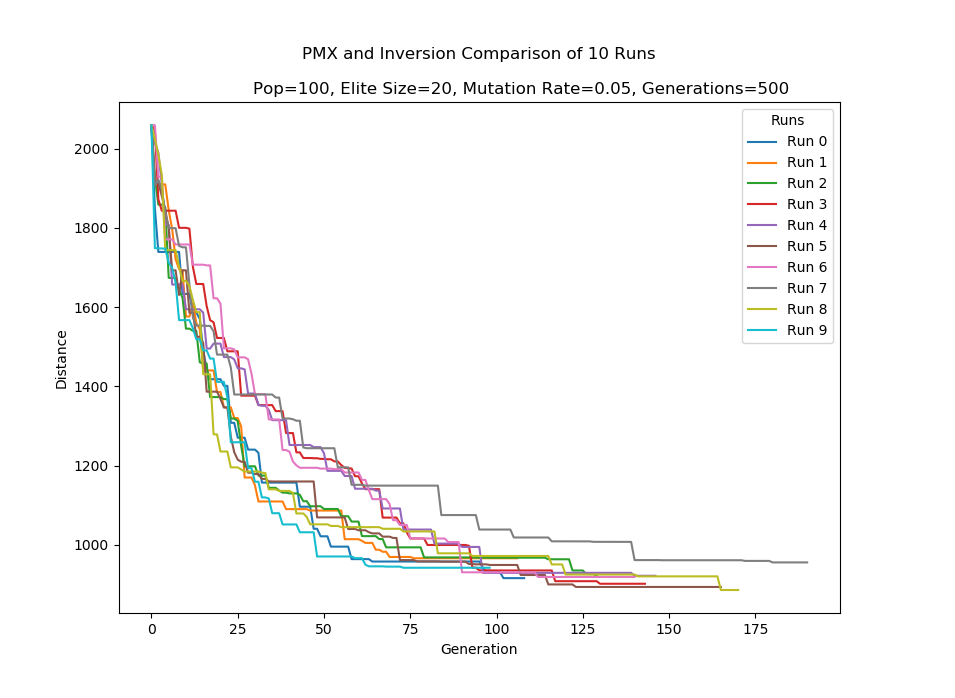

In [9]:
geneticAlgorithmVariationTest(population = pop, eliteSize = eSize, mutationRate = mRate, generations = gens, 
                              childMethod = 0, mutationMethod = 2, runs = 10)

## Observations

Given that there is a degree of randomness to the recombination and mutation methods, this test was designed to verify that there was variation between each run of the algorithm.

Even with only 10 runs, it became apparent that:

- While each run followed the same general trend downward, the number of generations that passed before the population became stagnant and ended the simulation varied across each run.
- The quality of the final route varied across each run even though they all started from the same initial population, demonstrating that the randomness is having an effect on the quality of the solutions.

In [17]:
def geneticAlgorithmComparisonPlot(population, eliteSize, mutationRate, generations, childMethods, mutationMethods):
    '''  
    Narrative: Generates a graph with the performance of each combination of childMethods and mutationMethods for
                a single run.

    Parameters:
        population: A list of possible routes to take between the cities.
        eliteSize: How many of the "fittest" routes to carry over into the next generation
        mutationRate: A value between 0.0-1.0.  The likelihood of a mutation occuring in a child.
        generations: The maximum number of generations to allow the algorithm to run for.
        cMethods: A list of the recombination method(s) to use.
        mMethods: A list of the mutation method(s) to use.
        runs: The number of times to run each simulation.
    '''
    pop = population
    progress = []
    progress.append(1 / TSP.rankRoutes(pop)[0][1])
    label = None
    tmpDF = pd.DataFrame()
    df = pd.DataFrame()
    j = 0
    
    for cMethod in childMethods:
        for mMethod in mutationMethods:
            label = TSP.childMethods[cMethod] + "," + TSP.mutationMethods[mMethod]
    
            while(j < generations and DetermineChange(progress[j], j)):
                pop = TSP.nextGeneration(pop, eliteSize, mutationRate, cMethod, mMethod)
                progress.append(1 / TSP.rankRoutes(pop)[0][1])
                j += 1
                
            tmpDF[label] = progress
            df = pd.concat([df, tmpDF], axis = 1)
            
            pop = population
            progress = []
            tmpDF = pd.DataFrame()
            j=0
            progress.append(1 / TSP.rankRoutes(pop)[0][1])
    
    plt.plot(df)
    plt.title(f"Pop={len(population)}, Elite Size={eliteSize}, Mutation Rate={mutationRate}, Generations={generations}")
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.legend(df, loc = "center left", bbox_to_anchor=(1, 0.5), title="Configurations")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


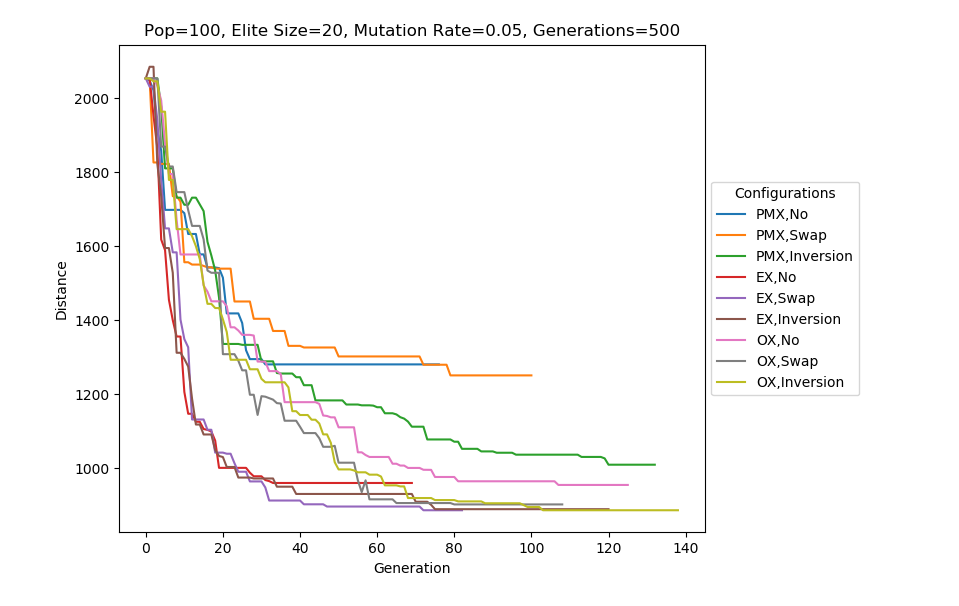

In [15]:
geneticAlgorithmComparisonPlot(population = pop, eliteSize = eSize, mutationRate = mRate, generations=gens,
                               childMethods = TSP.childMethods, mutationMethods = TSP.mutationMethods)

## Observations

This test was designed to get a sense of how the different combinations of recombination and mutation techniques would affect performance and have an idea of what kind of results may come from further tests.

This test did surpirse the team.  Before this, we thought that **Partially Mapped Crossover (PMX)** and **Edge Crossover (EX)** would have the best performance.  *However, PMX performed worse than EX and **Order Crossover (OX)** in all of its configurations.*  As this test simply performed a single run of the algorithm for each combination of recombination and mutation method, we were uncertain if this was simply due to randomness not being in PMX's favor in this case or if it was indicative of general performance, but it made us aware of something to look for in later testing.

This test also indicated that EX seemed to reach quality solutions over fewer generations than the other methods.  This could make it a more viable method to use if a decent solution is needed in a limited number of generations.

In [18]:
def GenerateTitle(cMethods, mMethods, runs):
    '''  
    Narrative: Generates a graph with the average performance of each combination of cMethods and mMethods over the
                specified number of runs with their variation.

    Parameters:
        population: A list of possible routes to take between the cities.
        eliteSize: How many of the "fittest" routes to carry over into the next generation
        mutationRate: A value between 0.0-1.0.  The likelihood of a mutation occuring in a child.
        generations: The maximum number of generations to allow the algorithm to run for.
        cMethods: A list of the recombination method(s) to use.
        mMethods: A list of the mutation method(s) to use.
        runs: The number of times to run each simulation.
    '''
    title = ""
    
    for cMethod in range(len(cMethods)):
        if cMethod == 0:
            title = title + TSP.childMethods[cMethods[cMethod]]
        elif cMethod < len(cMethods) - 1:
            title = title + ", " + TSP.childMethods[cMethods[cMethod]]
        else:
            title = title + " and " + TSP.childMethods[cMethods[cMethod]]
            
    title = title + " with "
    
    for mMethod in range(len(mMethods)):
        if mMethod == 0:
            title = title + TSP.mutationMethods[mMethods[mMethod]]
        elif mMethod < len(mMethods) - 1:
            title = title + ", " + TSP.mutationMethods[mMethods[mMethod]]
        else:
            title = title + " and " + TSP.mutationMethods[mMethods[mMethod]]
               
    title = title + f" Mutation. Average of {runs} Runs"
    
    return title

In [19]:
def geneticAlgorithmPerformanceTest(population, eliteSize, mutationRate, generations, cMethods, mMethods, runs):
    '''  
    Narrative: Generates a graph with the average performance of each combination of cMethods and mMethods over the
                specified number of runs with their variation.

    Parameters:
        population: A list of possible routes to take between the cities.
        eliteSize: How many of the "fittest" routes to carry over into the next generation
        mutationRate: A value between 0.0-1.0.  The likelihood of a mutation occuring in a child.
        generations: The maximum number of generations to allow the algorithm to run for.
        cMethods: A list of the recombination method(s) to use.
        mMethods: A list of the mutation method(s) to use.
        runs: The number of times to run each simulation.
    '''
    pop = population
    progress = [] 
    progress.append(1 / TSP.rankRoutes(pop)[0][1])
    
    label = None
    colTitle = None
    pltTitle = GenerateTitle(cMethods = cMethods, mMethods = mMethods, runs = runs)
    
    tmpDF = pd.DataFrame()
    df = pd.DataFrame()
    variation = pd.DataFrame()
    means = pd.DataFrame()
    var = None
    mean = None
    j = 0
    
    for childMethod in cMethods:
        for mutationMethod in mMethods:
            colTitle = TSP.childMethods[childMethod] + ", " + TSP.mutationMethods[mutationMethod]
            for i in range(runs):
                label = f"Run {i}"

                while(j < generations and DetermineChange(progress[j], j)):
                    pop = TSP.nextGeneration(pop, eliteSize, mutationRate, childMethod, mutationMethod)
                    progress.append(1 / TSP.rankRoutes(pop)[0][1])
                    j += 1

                DetermineChange(999, 999, True)

                tmpDF[label] = progress
                df = pd.concat([df, tmpDF], axis = 1)

                tmpDF = pd.DataFrame()
                pop = population
                progress = []
                progress.append(1 / TSP.rankRoutes(pop)[0][1])
                j = 0
    
            #var = df.std(axis = 1) / np.sqrt(len(df.columns) - df.isnull().sum(axis=1))  #Std. Error
            var = df.std(axis = 1)
            mean = df.mean(axis = 1)
            
            df = pd.DataFrame()
            
            tmpDF[colTitle] = var
            variation = pd.concat([variation, tmpDF], axis = 1)
            
            tmpDF = pd.DataFrame()
            tmpDF[colTitle] = mean
            means = pd.concat([means, tmpDF], axis = 1)
            
            tmpDF = pd.DataFrame()
    
    plt.plot(means)
    plt.title(f"""{pltTitle}\n
                Pop={len(population)}, Elite Size={eliteSize}, Mutation Rate={mutationRate}, Generations={generations}""")
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.legend(means, loc = "upper right", title="Combinations")
    
    for column in means:
        plt.fill_between(means.index, means[column] - variation[column], means[column] + variation[column], alpha = 0.2)
    
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


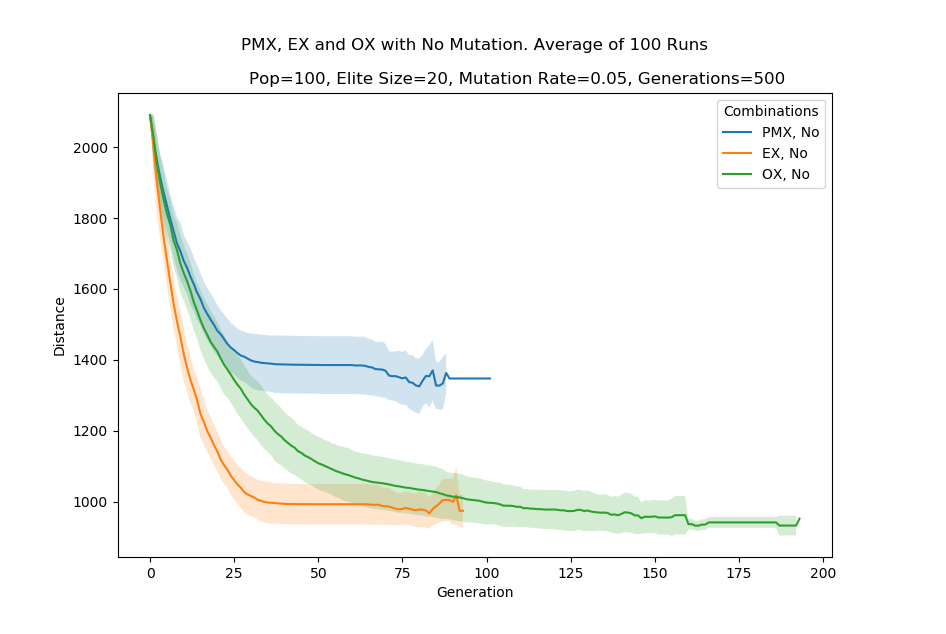

In [10]:
geneticAlgorithmPerformanceTest(pop, eSize, mRate, gens, cMethods = [0,1,2], mMethods = [0], runs = 100)

<IPython.core.display.Javascript object>


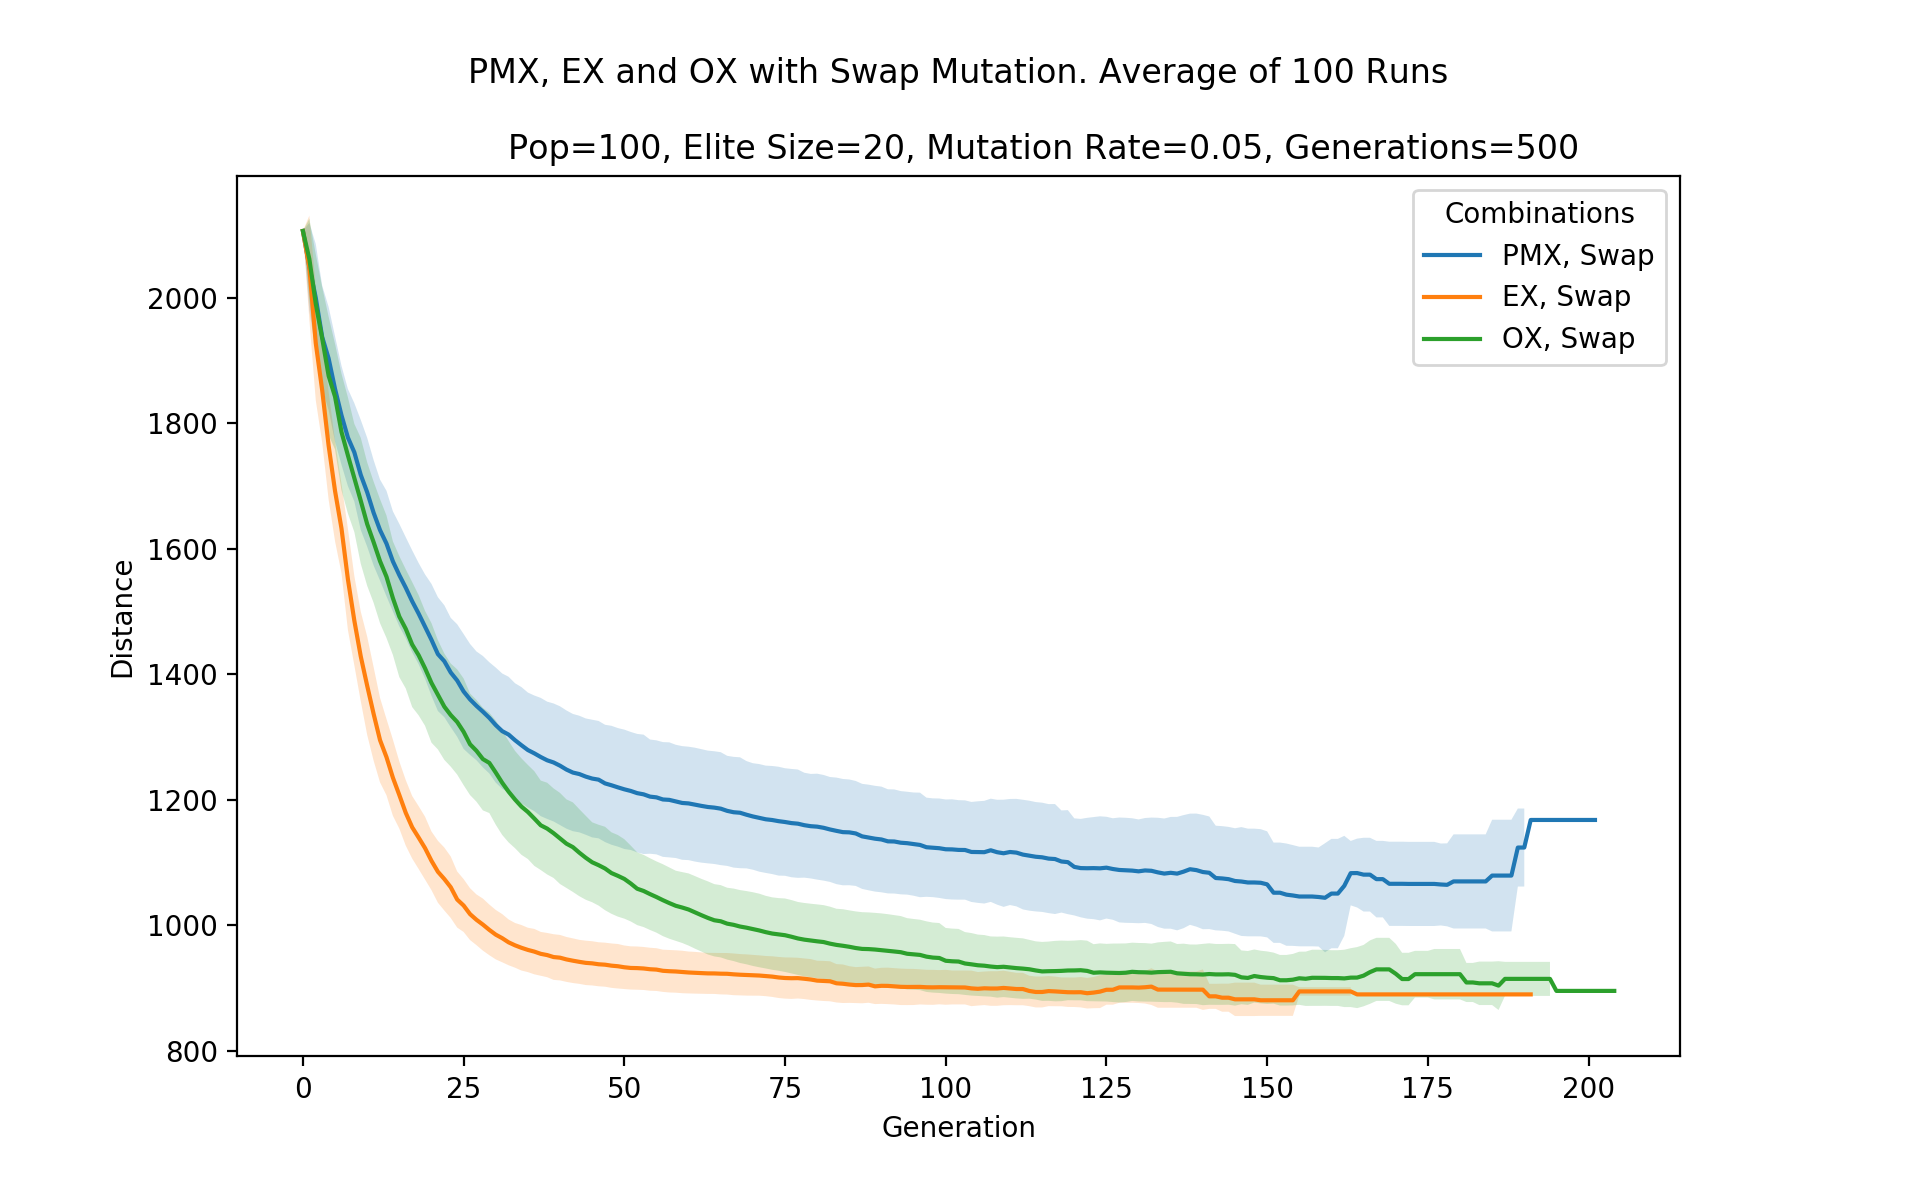

In [39]:
geneticAlgorithmPerformanceTest(pop, eSize, mRate, gens, cMethods = [0,1,2], mMethods = [1], runs = 100)

<IPython.core.display.Javascript object>


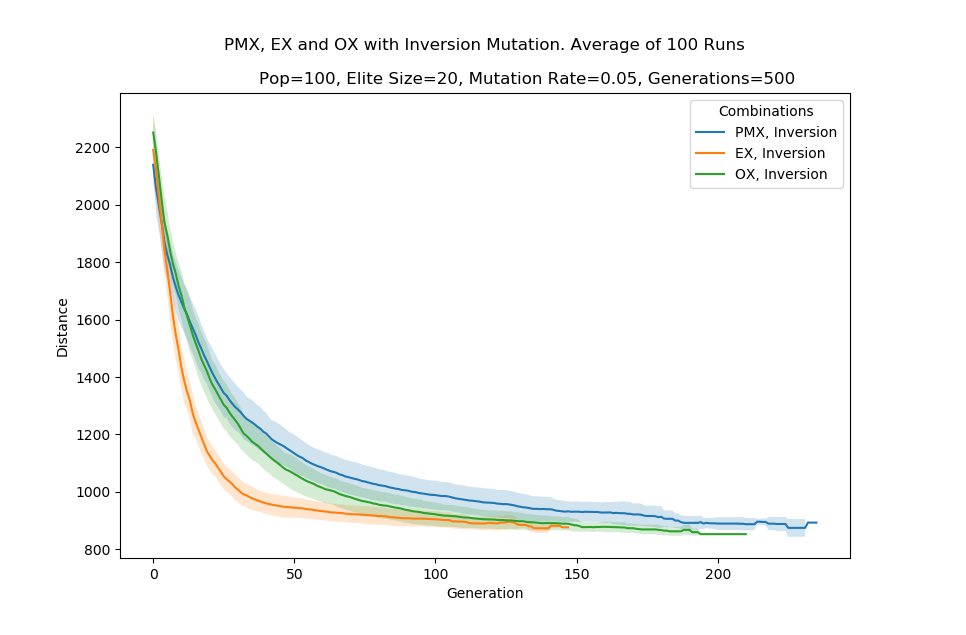

In [40]:
geneticAlgorithmPerformanceTest(pop, eSize, mRate, gens, cMethods = [0,1,2], mMethods = [2], runs = 100)

## Observations

The above tests were to compare the recombination techniques' average performance against one another with each mutation method.

- In each case, PMX performed the worst on average, though with inversion mutation its performance was close to being similar to EX and OX.
- EX took the fewest generations to find a decent solution, though OX could often find at least a slightly better solution before it finished running.
    - It is possible that by adjusting the parameters of the early exit function (**DetermineChange**), or by removing it entirely, EX could match or exceed OX's solutions.  
    - This could be worth testing; however, the function with its current parameters was designed to prevent the algorithm from running with little to no change and could simply lead to longer runtime for a marginally better solution.

<IPython.core.display.Javascript object>


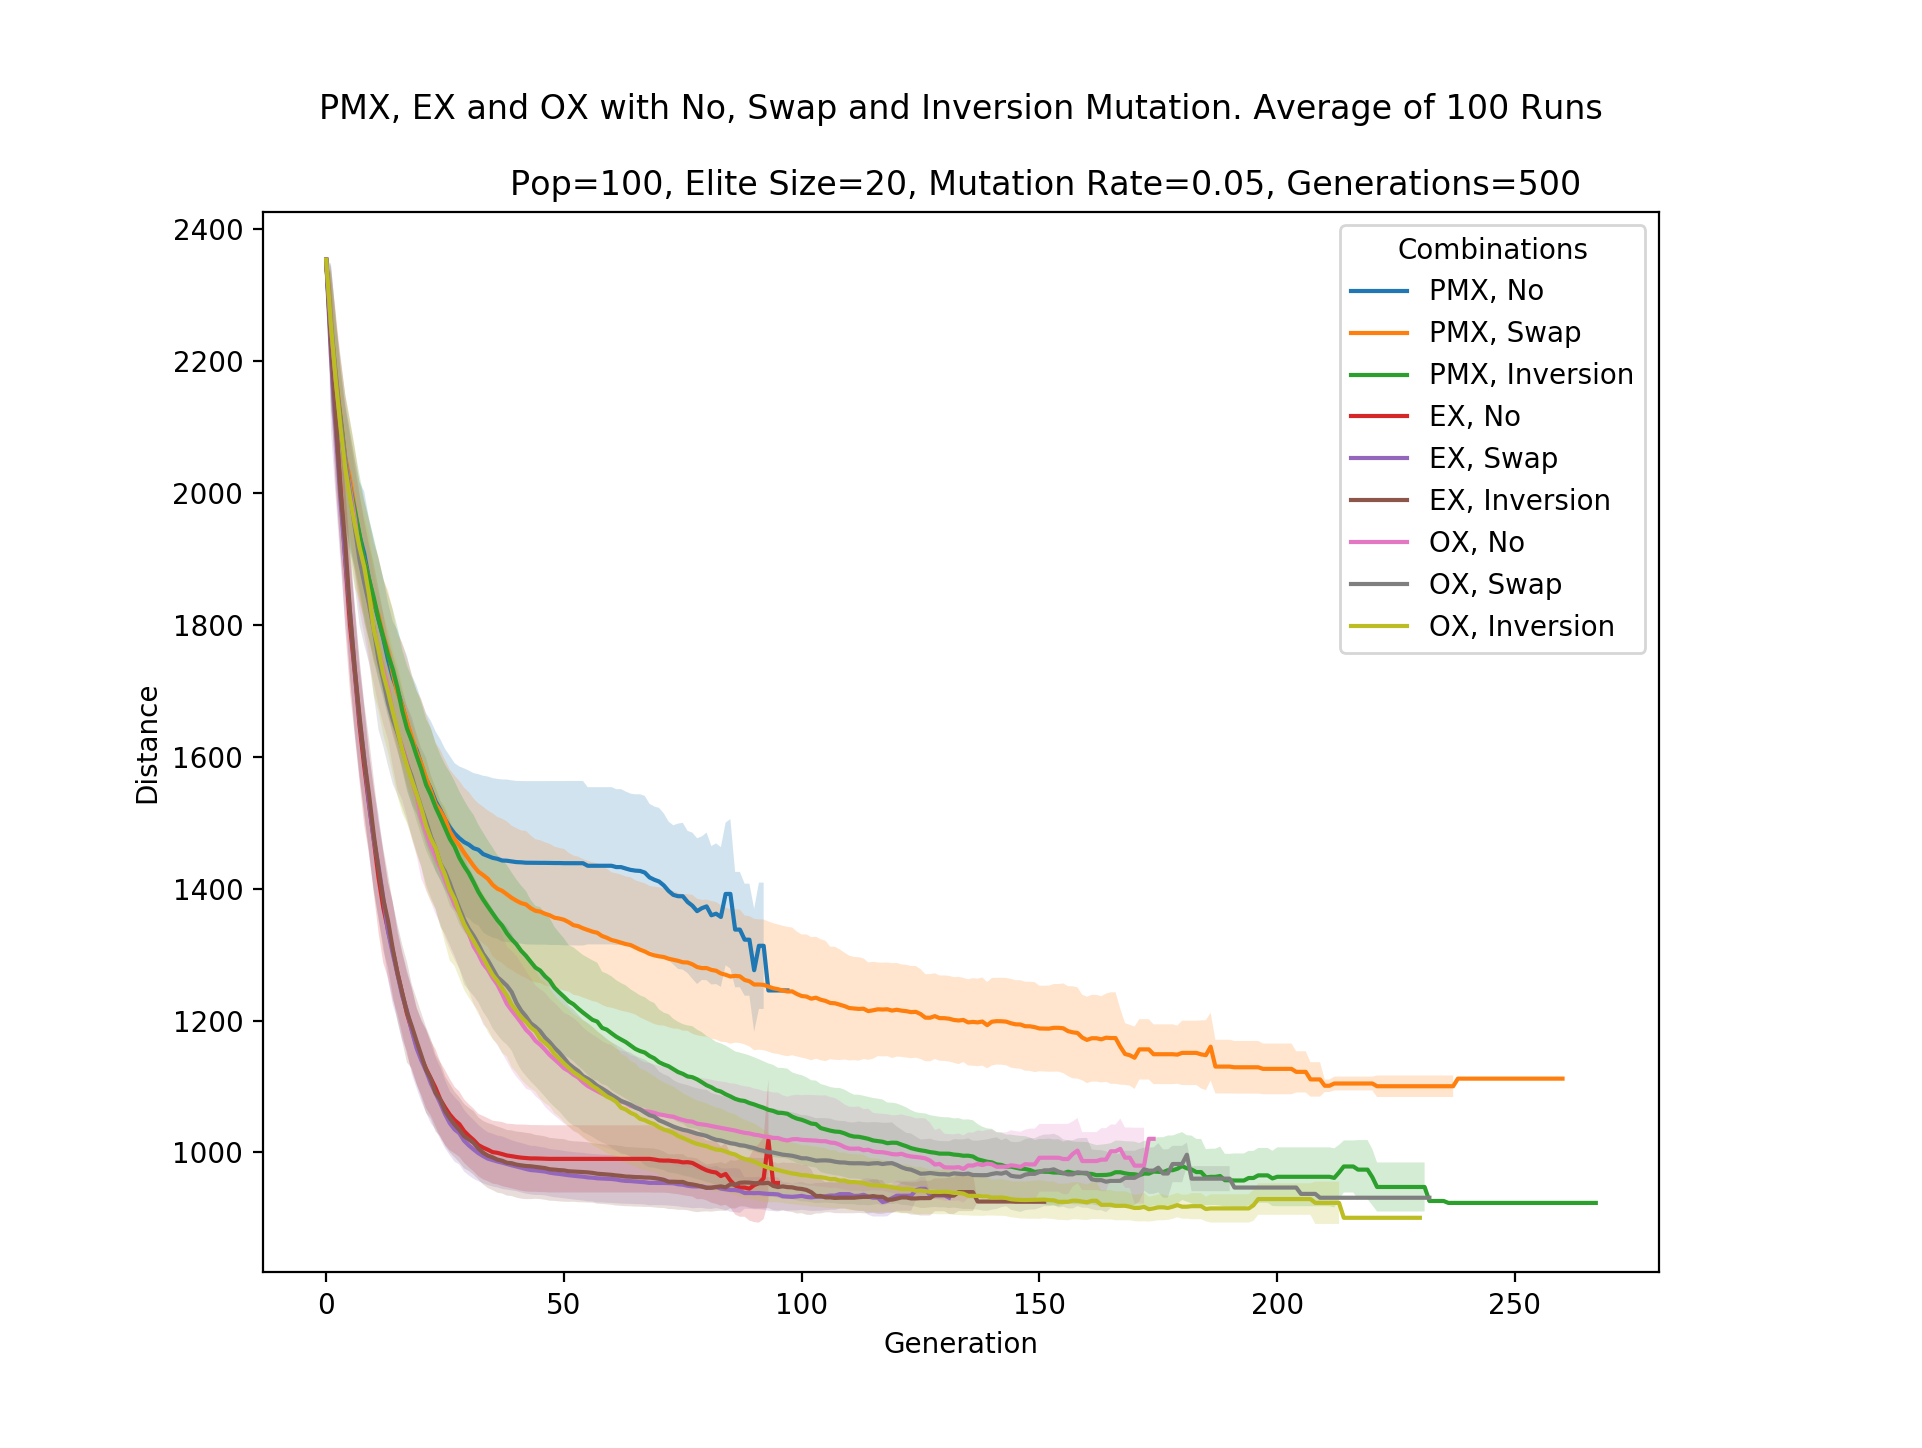

In [20]:
geneticAlgorithmPerformanceTest(pop, eSize, mRate, gens, cMethods = [0,1,2], mMethods = [0, 1, 2], runs = 100)

## Observations

This test was conducted to see if on average the performance of each combination of recombination and mutation techniques matched the results of the comparison test.

- On average, PMX with inversion mutation actually does seem to find better solutions that some combinations with OX, though the other combinations of PMX still have the worst performance.
- Combinations with EX still reached decent solutions in the shortest number of generations compared to the other combinations. 


## The following tests were designed to compare the effect of the mutation techniques on the recombination methods.

<IPython.core.display.Javascript object>


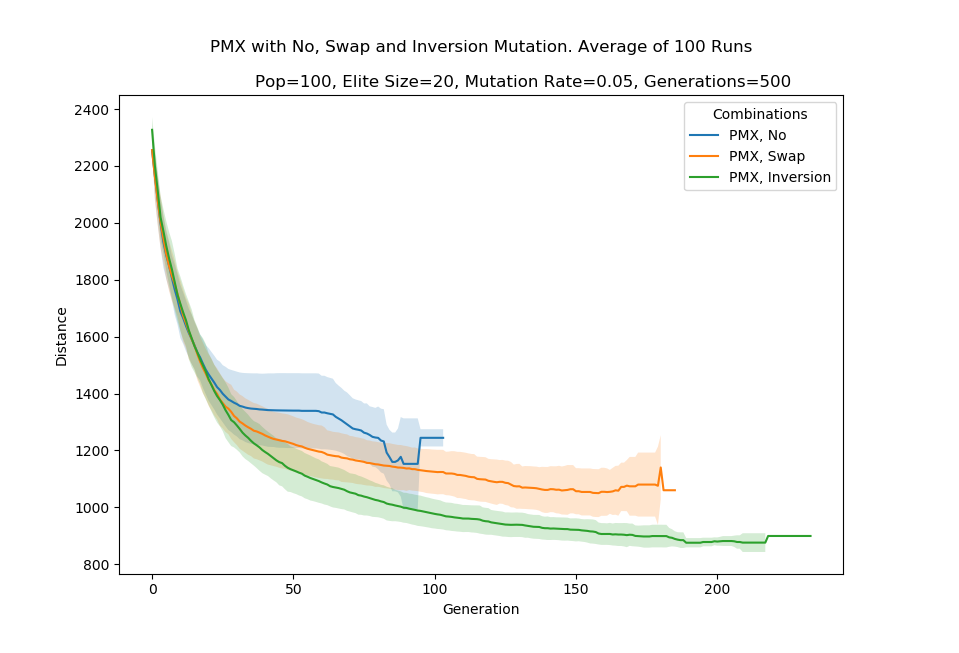

In [41]:
geneticAlgorithmPerformanceTest(pop, eSize, mRate, gens, cMethods = [0], mMethods = [0, 1, 2], runs = 100)

## Observations

Out of the three recombination methods explored here, PMX seemed to be affected the most by the mutation methods.  This is possibly because it not only focuses on the order of the elements in each route (like OX), but also on the specific *positions* of those elements.  Therefore, the mutations, which can modify the positions of elements, would change how PMX performs overall.

<IPython.core.display.Javascript object>


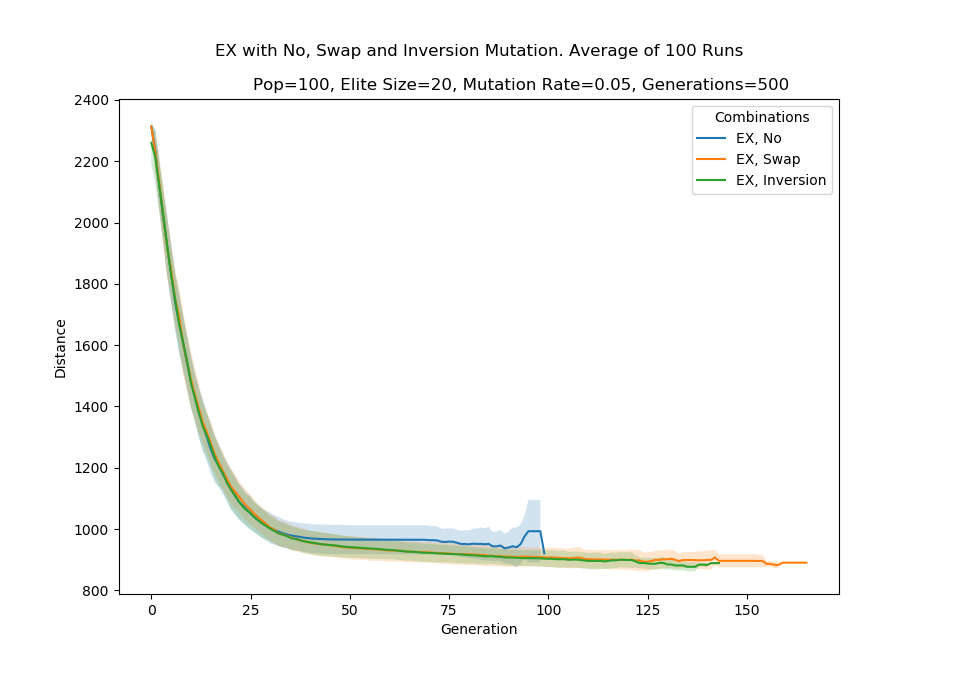

In [42]:
geneticAlgorithmPerformanceTest(pop, eSize, mRate, gens, cMethods = [1], mMethods = [0, 1, 2], runs = 100)

<IPython.core.display.Javascript object>


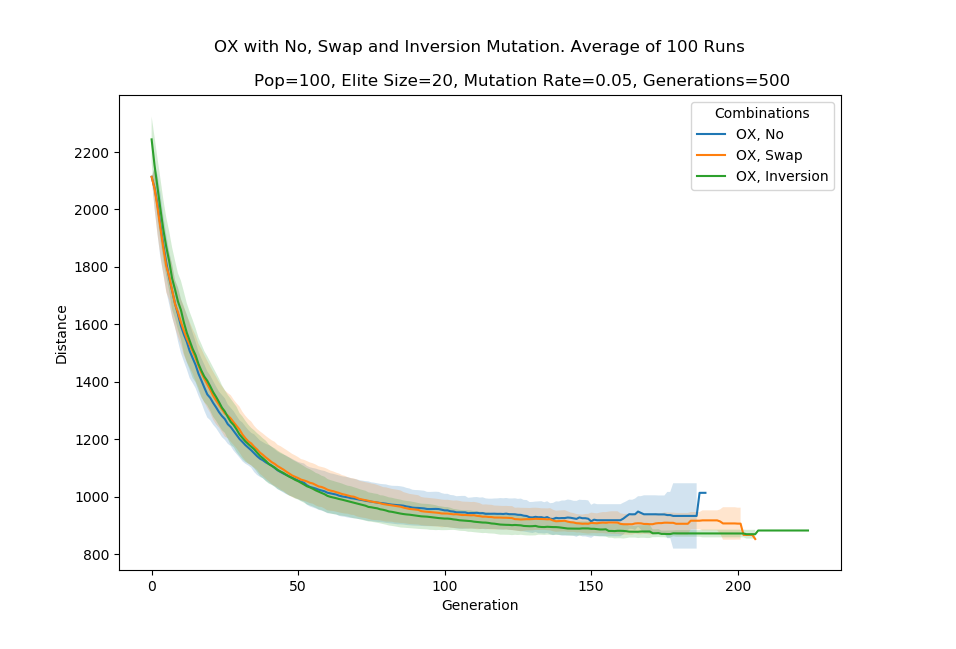

In [43]:
geneticAlgorithmPerformanceTest(pop, eSize, mRate, gens, cMethods = [2], mMethods = [0, 1, 2], runs = 100)

## Oberservations

Overall, having mutation performs better on average than just using recombination techniques with **inversion mutation** having similar if not slightly better performance than **swap mutation**, though the effect is most apparent in PMX and slight in EX and OX.